<a href="https://colab.research.google.com/github/capofwesh20/Comment-Toxicity-Classification/blob/main/LSTM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
%%capture
!pip install talos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import numpy as np, pandas as pd
import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


**Data Exploration**

In [ ]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

# **Data Pre-processing**

**Text Normalization**

1. Removing Characters in between Text
2. Removing Repeated Characters
3. Converting data to lower-case
4. Removing Numbers from the data
5. Remove Punctuation
6. Remove Whitespaces
7. Removing spaces in between words
8. Removing "\n"
9. Remove Non-english characters

In [ ]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [ ]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

**Cleaning Training Data**

In [ ]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [ ]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

**Lemmatization**

In [ ]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [ ]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

**Lemmatizing Training Data**

In [ ]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

**Lemmatizing Test Data**

In [ ]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

**Stopwords Removal**

In [ ]:
stopword_list=STOP_WORDS

**Adding Single and Dual to STOP_WORDS**

In [ ]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [ ]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [ ]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


**Checking for other words that we may need in STOP_WORDS**

In [ ]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [ ]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
len(potential_stopwords)

159571

**Combining all the sentences in the list into a single string**

In [ ]:
def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

In [ ]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

Counting the number of words in each of the 4 strings

In [ ]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [ ]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

**Converting Dictionaries to Dataframe**

In [ ]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

**Getting Dataframe output in descending order**

In [ ]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

**Looking for common terms in all top 50 dataframes**

In [ ]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))

In [ ]:
print(common_potential_stopwords)

['fact', 'time', 'comment', 'good', 'block', 'people', 'fuck', 'delete', 'information', 'thing', 'edit', 'reference', 'new', 'use', 'talk', 'don', 'change', 'need', 'list', 'read', 'find', 'question', 'help', 'thank', 'way', 'image', 'point', 'think', 'try', 'wikipedia', 'mean', 'article', 'editor', 'deletion', 'like', 'want', 'remove', 'source', 'work', 'doe', 'page', 'look', 'write', 'know', 'add', 'link', 'user', 'section']


**Retaining certain words and removing others from the above list**

In [ ]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

**Adding above retrived words into the stopwords list**

In [ ]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!



Removing Stopwords from Training Data **bold text**

In [ ]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [ ]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

processed_train_data[152458]

  0%|          | 0/159571 [00:00<?, ?it/s]

'agree graemel intention revert nazi protect report revert rule notice board post report revert nazi graemel revert nazi unacceptable site admins feel unjustly revert hour period report revert noticeboard'

**Removing Stopwords from Test Data**

In [ ]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=153164): 
    processed_test_data.append(remove_stopwords(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

In [ ]:
processed_test_data[1528]

'need help'

**Model building**

In [ ]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

**Tokenization**

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [ ]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  148917



 **Padding**

In [ ]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [ ]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   578    11 32199   239   192    11 32199   239    90    11   579
    11   116   366   578     1  1082   116   338  5356   116   119    11
   387   269   366   578    11     1  1341   116    11   387     2    32
   116   578   192   116   172    46    84   579   116   578    11     2
   488   105    10  1087   403  1073    11  2401   489    36   116    11
   192   407   366     9   255   192   242   150   109    18    19    29
   172    77    19     3   257  4540     4    11 32199   239   192    11
 32199   239    90   171   387   312    68   579    34    44    77   423
  1550    34   171     8   579  1268    77  1638   134    10   134  4671
   134    94    44   565  1255    17    77  1338   118   134  1577    77
  1134     4   507    77   434    31   171    68    34   168  2207   449
    31   315  1529    70   172   236   150   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   579
     4    31   171   192    

In [ ]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [ ]:
X_t = X_t[indices]
labels = y[indices]

**Splitting data into Training and Validation Set**

In [ ]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [ ]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12254  1293  6769   380  6304  1118]
validation:  [3040  302 1680   98 1573  287]


**Importing Fast Text**

In [ ]:
embedding_dim_fasttext = 300
embeddings_index_fasttext = {}
f = open('/content/drive/MyDrive/Colab Notebooks/New research_folder1/wiki-news-300d-1M-subword.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [ ]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


**Creating Model**

**Talos Grid Search for LSTM Model**

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 9ms/step - loss: 0.0769 - accuracy: 0.9202 - val_loss: 0.0562 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0551 - accuracy: 0.9932 - val_loss: 0.0556 - val_accuracy: 0.9937


  6%|▌         | 1/18 [01:21<23:03, 81.36s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0834 - accuracy: 0.9003 - val_loss: 0.0568 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0578 - accuracy: 0.9935 - val_loss: 0.0545 - val_accuracy: 0.9937


 11%|█         | 2/18 [02:36<20:40, 77.55s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0752 - accuracy: 0.9316 - val_loss: 0.0557 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0549 - accuracy: 0.9927 - val_loss: 0.0524 - val_accuracy: 0.9937


 17%|█▋        | 3/18 [03:51<19:06, 76.45s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0781 - accuracy: 0.9437 - val_loss: 0.0560 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0561 - accuracy: 0.9941 - val_loss: 0.0522 - val_accuracy: 0.9937


 22%|██▏       | 4/18 [05:06<17:43, 76.00s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0733 - accuracy: 0.9304 - val_loss: 0.0553 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0543 - accuracy: 0.9942 - val_loss: 0.0519 - val_accuracy: 0.9937


 28%|██▊       | 5/18 [06:22<16:26, 75.89s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0752 - accuracy: 0.9354 - val_loss: 0.0552 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0553 - accuracy: 0.9927 - val_loss: 0.0522 - val_accuracy: 0.9937


 33%|███▎      | 6/18 [07:38<15:10, 75.84s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0738 - accuracy: 0.9138 - val_loss: 0.0569 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0542 - accuracy: 0.9940 - val_loss: 0.0518 - val_accuracy: 0.9937


 39%|███▉      | 7/18 [09:00<14:19, 78.13s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0779 - accuracy: 0.8810 - val_loss: 0.0588 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0558 - accuracy: 0.9902 - val_loss: 0.0530 - val_accuracy: 0.9937


 44%|████▍     | 8/18 [10:23<13:15, 79.54s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0747 - accuracy: 0.9216 - val_loss: 0.0577 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0544 - accuracy: 0.9938 - val_loss: 0.0522 - val_accuracy: 0.9937


 50%|█████     | 9/18 [11:45<12:03, 80.41s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0781 - accuracy: 0.9085 - val_loss: 0.0568 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0554 - accuracy: 0.9926 - val_loss: 0.0520 - val_accuracy: 0.9937


 56%|█████▌    | 10/18 [13:08<10:49, 81.24s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0695 - accuracy: 0.9490 - val_loss: 0.0548 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0534 - accuracy: 0.9940 - val_loss: 0.0523 - val_accuracy: 0.9937


 61%|██████    | 11/18 [14:32<09:32, 81.81s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0752 - accuracy: 0.9375 - val_loss: 0.0558 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0554 - accuracy: 0.9939 - val_loss: 0.0521 - val_accuracy: 0.9937


 67%|██████▋   | 12/18 [15:54<08:11, 81.99s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0752 - accuracy: 0.9152 - val_loss: 0.0557 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0551 - accuracy: 0.9916 - val_loss: 0.0529 - val_accuracy: 0.9937


 72%|███████▏  | 13/18 [17:09<06:39, 79.90s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0821 - accuracy: 0.8377 - val_loss: 0.0575 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0570 - accuracy: 0.9919 - val_loss: 0.0525 - val_accuracy: 0.9937


 78%|███████▊  | 14/18 [18:24<05:13, 78.42s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0734 - accuracy: 0.9132 - val_loss: 0.0543 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0533 - accuracy: 0.9929 - val_loss: 0.0506 - val_accuracy: 0.9937


 83%|████████▎ | 15/18 [19:39<03:52, 77.44s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0751 - accuracy: 0.9186 - val_loss: 0.0559 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0554 - accuracy: 0.9940 - val_loss: 0.0521 - val_accuracy: 0.9937


 89%|████████▉ | 16/18 [20:55<02:33, 76.81s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0721 - accuracy: 0.9451 - val_loss: 0.0570 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0540 - accuracy: 0.9926 - val_loss: 0.0511 - val_accuracy: 0.9936


 94%|█████████▍| 17/18 [22:10<01:16, 76.34s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0804 - accuracy: 0.9158 - val_loss: 0.0555 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0555 - accuracy: 0.9938 - val_loss: 0.0522 - val_accuracy: 0.9937


100%|██████████| 18/18 [23:25<00:00, 78.09s/it]


In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

0

In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[80.61579203605652, 40, 'sigmoid', '04/29/23-063933',
        '04/29/23-063813', 'adam', 0.1, 32, 'relu', 2, 30, 2, 0],
       [74.19877815246582, 40, 'sigmoid', '04/29/23-064048',
        '04/29/23-063934', 'adam', 0.2, 32, 'relu', 2, 30, 2, 1],
       [74.63971638679504, 60, 'sigmoid', '04/29/23-065907',
        '04/29/23-065752', 'adam', 0.2, 32, 'relu', 2, 40, 2, 2],
       [74.42103338241577, 60, 'sigmoid', '04/29/23-065752',
        '04/29/23-065637', 'adam', 0.1, 32, 'relu', 2, 40, 2, 3],
       [74.27536296844482, 60, 'sigmoid', '04/29/23-065636',
        '04/29/23-065522', 'adam', 0.2, 32, 'relu', 2, 30, 2, 4],
       [74.39411425590515, 60, 'sigmoid', '04/29/23-065521',
        '04/29/23-065407', 'adam', 0.1, 32, 'relu', 2, 30, 2, 5],
       [81.64191555976868, 50, 'sigmoid', '04/29/23-065406',
        '04/29/23-065245', 'adam', 0.2, 32, 'relu', 2, 50, 2, 6],
       [82.37059998512268, 50, 'sigmoid', '04/29/23-065244',
        '04/29/23-065121', 'adam', 0.1, 32, 'relu'

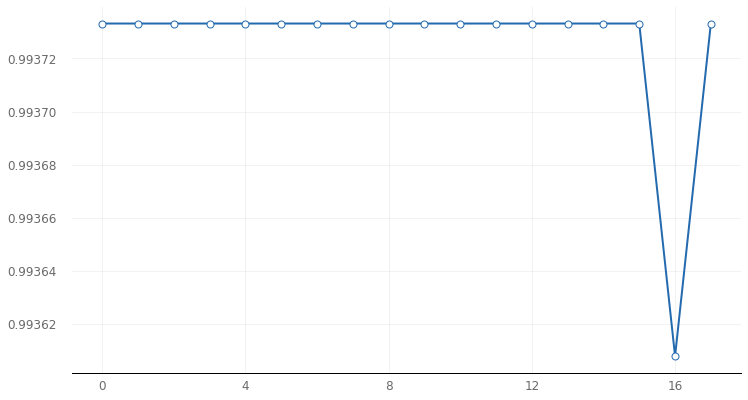

In [ ]:
analyze_object.plot_line('val_accuracy')

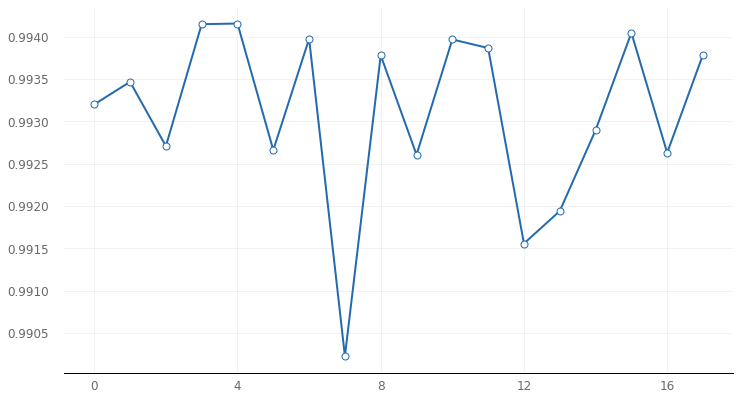

In [ ]:
analyze_object.plot_line('accuracy')

**Talos Grid Search for LSTM-CNN Model**

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

  x = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], padding='same', activation='relu', kernel_initializer='he_uniform')(x)

  x = MaxPooling1D(params['pool_size'])(x)
  
  x = GlobalMaxPool1D()(x)
  
  x = BatchNormalization()(x)
  
  x = Dense(params['output_1_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)

  x = Dense(params['output_2_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [50,60],
    'output_1_count_dense': [40,50],
    'output_2_count_dense': [30,40],
    'filters' : [64],
    'kernel_size' : [3],
    'batch_size': [32],
    'pool_size': [3],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/16 [00:00<?, ?it/s]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 54s 11ms/step - loss: 0.0718 - accuracy: 0.9151 - val_loss: 0.0892 - val_accuracy: 0.9930
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0555 - accuracy: 0.9839 - val_loss: 0.0543 - val_accuracy: 0.9937


  6%|▋         | 1/16 [01:39<24:45, 99.01s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 11ms/step - loss: 0.0767 - accuracy: 0.8996 - val_loss: 0.0616 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0577 - accuracy: 0.9926 - val_loss: 0.0531 - val_accuracy: 0.9937


 12%|█▎        | 2/16 [03:12<22:22, 95.87s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 11ms/step - loss: 0.0698 - accuracy: 0.9320 - val_loss: 0.0554 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0554 - accuracy: 0.9891 - val_loss: 0.0605 - val_accuracy: 0.9937


 19%|█▉        | 3/16 [04:45<20:29, 94.61s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 11ms/step - loss: 0.0761 - accuracy: 0.8546 - val_loss: 0.0788 - val_accuracy: 0.9919
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0564 - accuracy: 0.9887 - val_loss: 0.0596 - val_accuracy: 0.9937


 25%|██▌       | 4/16 [06:19<18:49, 94.10s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 11ms/step - loss: 0.0709 - accuracy: 0.9012 - val_loss: 0.0555 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0553 - accuracy: 0.9858 - val_loss: 0.0521 - val_accuracy: 0.9937


 31%|███▏      | 5/16 [07:52<17:13, 93.94s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 11ms/step - loss: 0.0742 - accuracy: 0.9057 - val_loss: 0.0560 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0578 - accuracy: 0.9915 - val_loss: 0.0537 - val_accuracy: 0.9937


 38%|███▊      | 6/16 [09:27<15:42, 94.30s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 11ms/step - loss: 0.0706 - accuracy: 0.9316 - val_loss: 0.0715 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0551 - accuracy: 0.9800 - val_loss: 0.0622 - val_accuracy: 0.9833


 44%|████▍     | 7/16 [11:01<14:07, 94.20s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 11ms/step - loss: 0.0722 - accuracy: 0.9055 - val_loss: 0.0603 - val_accuracy: 0.9930
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0559 - accuracy: 0.9872 - val_loss: 0.0637 - val_accuracy: 0.9937


 50%|█████     | 8/16 [12:35<12:32, 94.06s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0736 - accuracy: 0.8798 - val_loss: 0.0661 - val_accuracy: 0.9694
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0554 - accuracy: 0.9821 - val_loss: 0.0545 - val_accuracy: 0.9937


 56%|█████▋    | 9/16 [14:05<10:49, 92.74s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0788 - accuracy: 0.8956 - val_loss: 0.0595 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0573 - accuracy: 0.9920 - val_loss: 0.0573 - val_accuracy: 0.9937


 62%|██████▎   | 10/16 [15:34<09:10, 91.77s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0698 - accuracy: 0.8831 - val_loss: 0.0651 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0548 - accuracy: 0.9760 - val_loss: 0.0514 - val_accuracy: 0.9871


 69%|██████▉   | 11/16 [17:04<07:35, 91.16s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0743 - accuracy: 0.9207 - val_loss: 0.0567 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0561 - accuracy: 0.9926 - val_loss: 0.0517 - val_accuracy: 0.9935


 75%|███████▌  | 12/16 [18:34<06:02, 90.67s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0707 - accuracy: 0.9251 - val_loss: 0.0761 - val_accuracy: 0.9930
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0552 - accuracy: 0.9856 - val_loss: 0.0530 - val_accuracy: 0.9930


 81%|████████▏ | 13/16 [20:03<04:30, 90.27s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0724 - accuracy: 0.9246 - val_loss: 0.0611 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0557 - accuracy: 0.9933 - val_loss: 0.0554 - val_accuracy: 0.9937


 88%|████████▊ | 14/16 [21:33<03:00, 90.01s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0686 - accuracy: 0.9378 - val_loss: 0.0589 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0540 - accuracy: 0.9903 - val_loss: 0.0524 - val_accuracy: 0.9934


 94%|█████████▍| 15/16 [23:02<01:29, 89.77s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0730 - accuracy: 0.9131 - val_loss: 0.0570 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0563 - accuracy: 0.9915 - val_loss: 0.0543 - val_accuracy: 0.9935


100%|██████████| 16/16 [24:31<00:00, 91.97s/it]


In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

0

# **Training Model with Best Parameters**
**LSTM**

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44675400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                             

In [ ]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0730 - accuracy: 0.9427 - val_loss: 0.0555 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0546 - accuracy: 0.9940 - val_loss: 0.0516 - val_accuracy: 0.9937


**LSTM-CNN**

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

NameError: ignored

In [ ]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_2 = Model(inputs=inp, outputs=preds)
model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44675400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 50)           70200     
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           9664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 64)           0         
 )                                                               
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

In [ ]:
model_info_2=model_2.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 48s 11ms/step - loss: 0.0731 - accuracy: 0.9062 - val_loss: 0.0554 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0568 - accuracy: 0.9923 - val_loss: 0.0573 - val_accuracy: 0.9937


# **Plotting Graphs**
**LSTM**

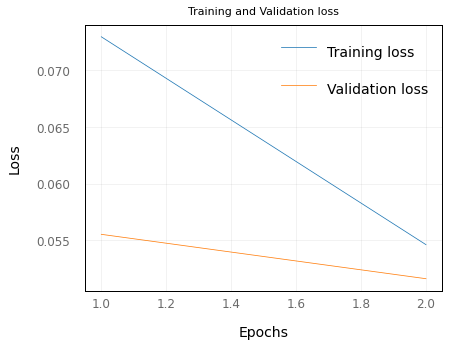

In [ ]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

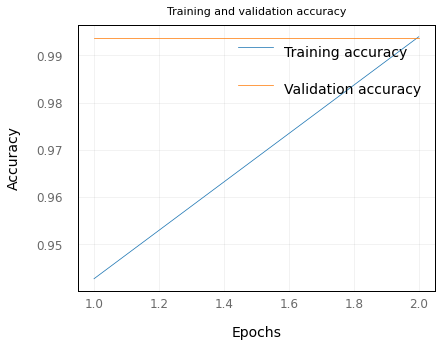

In [ ]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

**LSTM-CNN**

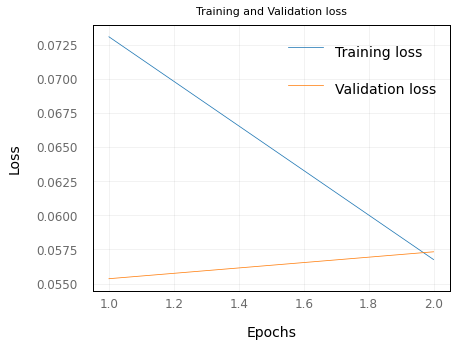

In [ ]:
loss = model_info_2.history['loss']
val_loss = model_info_2.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

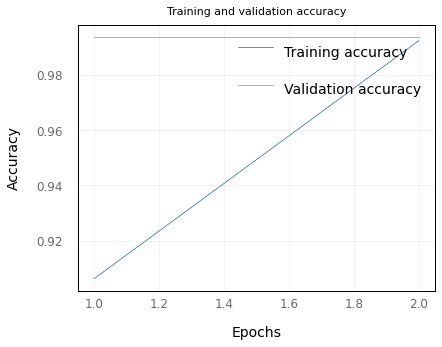

In [ ]:
accuracy = model_info_2.history['accuracy']
val_accuracy = model_info_2.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

**Saving the Model**

In [ ]:
model_1.save(filepath="/content/model")



In [ ]:
model_2.save(filepath="/content/model_2")

In [ ]:
loaded_model_1 = keras.models.load_model(filepath="/content/model")

loaded_model_2 = keras.models.load_model(filepath="/content/model_2")


# **Generating the Output**
**LSTM**

In [ ]:
test_values_1 = loaded_model_1.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 518s 3ms/step


In [ ]:
sample_submission = pd.read_csv('/content/sample_submission.csv')
test_values_1=pd.DataFrame(test_values_1,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_1],axis=1)
combined_submission.to_csv('File_Path', index=False)

**LSTM-CNN**

In [ ]:
test_values_2 = loaded_model_2.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 554s 4ms/step


In [ ]:
sample_submission = pd.read_csv('/content/sample_submission.csv')
test_values_2=pd.DataFrame(test_values_2,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_2],axis=1)
combined_submission.to_csv('File_Path', index=False)

**Testing the Created Model**

In [ ]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = model_1.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [ ]:
toxicity_level('Hello, How are you?')

1/1 [==============================] - 0s 459ms/step
Toxicity levels for 'Hello, How are you?':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('get the fuck away from me @sshole!!')

1/1 [==============================] - 0s 33ms/step
Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         96%
Severe Toxic:  7%
Obscene:       85%
Threat:        1%
Insult:        57%
Identity Hate: 3%



In [ ]:
toxicity_level('go jump off a bridge jerk')

1/1 [==============================] - 0s 31ms/step
Toxicity levels for 'go jump off a bridge jerk':
Toxic:         77%
Severe Toxic:  1%
Obscene:       44%
Threat:        1%
Insult:        31%
Identity Hate: 2%

